In [4]:
%pip install xgboost

  Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.28.9-py3-none-manylinux_2_18_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)
Using cached nvidia_nccl_cu12-2.28.9-py3-none-manylinux_2_18_x86_64.whl (296.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))
import config

# Settings
np.random.seed(config.RANDOM_STATE)
plt.rcParams['figure.figsize'] = (12, 6)

#### Load and clean data

In [8]:
df = pd.read_csv(config.RAW_DATA_FILE, delimiter=';')
print(f"Original shape: {df.shape}")

# Apply same cleaning as baseline
df['age'] = (df['age'] / 365.25).round().astype(int)
df = df[(df['ap_hi'] > 0) & (df['ap_hi'] < 250)]
df = df[(df['ap_lo'] > 0) & (df['ap_lo'] < 200)]
df = df[df['ap_hi'] > df['ap_lo']]
df = df[(df['height'] > 120) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]

print(f"After cleaning: {df.shape}")
df.head()

Original shape: (70000, 13)
After cleaning: (68615, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48,1,156,56.0,100,60,1,1,0,0,0,0


#### Feature Engineering

In [9]:
print("=" * 50)
print("FEATURE ENGINEERING")
print("=" * 50)

# 1. BMI (Body Mass Index)
df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
print("✓ BMI created")

# 2. Pulse Pressure
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
print("✓ Pulse Pressure created")

# 3. Mean Arterial Pressure
df['map'] = (df['ap_hi'] + 2 * df['ap_lo']) / 3
print("✓ Mean Arterial Pressure created")

# 4. Age Groups
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 40, 50, 60, 100],
                         labels=['young', 'middle', 'senior', 'elderly'])
print("✓ Age Groups created")

# 5. BMI Categories
df['bmi_category'] = pd.cut(df['bmi'],
                            bins=[0, 18.5, 25, 30, 100],
                            labels=['underweight', 'normal', 'overweight', 'obese'])
print("✓ BMI Categories created")

# 6. Blood Pressure Categories
def bp_category(row):
    if row['ap_hi'] < 120 and row['ap_lo'] < 80:
        return 'normal'
    elif row['ap_hi'] < 130 and row['ap_lo'] < 80:
        return 'elevated'
    elif row['ap_hi'] < 140 or row['ap_lo'] < 90:
        return 'hypertension_stage1'
    else:
        return 'hypertension_stage2'

df['bp_category'] = df.apply(bp_category, axis=1)
print("✓ Blood Pressure Categories created")

# 7. Health Risk Score (composite)
df['health_risk_score'] = (
    (df['cholesterol'] - 1) * 2 +  # 0, 2, 4
    (df['gluc'] - 1) * 2 +           # 0, 2, 4
    df['smoke'] * 3 +                # 0, 3
    df['alco'] * 2 -                 # 0, 2
    df['active'] * 2                 # -2, 0
)
print("✓ Health Risk Score created")

# 8. Gender-Age Interaction
df['gender_age_interaction'] = df['gender'] * df['age']
print("✓ Gender-Age Interaction created")

# 9. Weight-Height Ratio
df['weight_height_ratio'] = df['weight'] / df['height']
print("✓ Weight-Height Ratio created")

# 10. Cholesterol-Glucose Interaction
df['chol_gluc_interaction'] = df['cholesterol'] * df['gluc']
print("✓ Cholesterol-Glucose Interaction created")

print(f"\n📊 New shape: {df.shape}")
print(f"📈 New features added: {df.shape[1] - 13}")

# Show new features
print("\nNew numerical features:")
new_numeric_features = ['bmi', 'pulse_pressure', 'map', 'health_risk_score', 
                        'gender_age_interaction', 'weight_height_ratio', 
                        'chol_gluc_interaction']
df[new_numeric_features].describe()

FEATURE ENGINEERING
✓ BMI created
✓ Pulse Pressure created
✓ Mean Arterial Pressure created
✓ Age Groups created
✓ BMI Categories created
✓ Blood Pressure Categories created
✓ Health Risk Score created
✓ Gender-Age Interaction created
✓ Weight-Height Ratio created
✓ Cholesterol-Glucose Interaction created

📊 New shape: (68615, 23)
📈 New features added: 10

New numerical features:


,bmi,pulse_pressure,map,health_risk_score,gender_age_interaction,weight_height_ratio,chol_gluc_interaction
count,68615.000000,68615.000000,68615.000000,68615.000000,68615.000000,68615.000000,68615.000000
mean,27.443873,45.398601,96.408259,-0.055294,71.793733,0.450459,1.847730
std,5.221003,11.761010,11.106120,2.524790,26.978133,0.083212,1.873655
min,10.726644,4.000000,12.000000,-2.000000,30.000000,0.182353,1.000000
25%,23.875115,40.000000,93.333333,-2.000000,52.000000,0.393939,1.000000
50%,26.346494,40.000000,93.333333,0.000000,59.000000,0.435897,1.000000
75%,30.116213,50.000000,103.333333,1.000000,98.000000,0.494186,2.000000
max,108.169847,160.000000,186.666667,13.000000,130.000000,1.336000,9.000000


#### Encode Categorical Features

In [10]:
print("=" * 50)
print("ENCODING CATEGORICAL FEATURES")
print("=" * 50)

# One-hot encoding for new categorical features
df_encoded = pd.get_dummies(df, columns=['age_group', 'bmi_category', 'bp_category'], 
                            drop_first=True)

print(f"After encoding shape: {df_encoded.shape}")
print(f"Total features: {df_encoded.shape[1] - 2}")  # -2 for id and target

df_encoded.head()

ENCODING CATEGORICAL FEATURES
After encoding shape: (68615, 29)
Total features: 27


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,chol_gluc_interaction,age_group_middle,age_group_senior,age_group_elderly,bmi_category_normal,bmi_category_overweight,bmi_category_obese,bp_category_hypertension_stage1,bp_category_hypertension_stage2,bp_category_normal
0,0,50,2,168,62.0,110,80,1,1,0,...,1,True,False,False,True,False,False,True,False,False
1,1,55,1,156,85.0,140,90,3,1,0,...,3,False,True,False,False,False,True,False,True,False
2,2,52,1,165,64.0,130,70,3,1,0,...,3,False,True,False,True,False,False,True,False,False
3,3,48,2,169,82.0,150,100,1,1,0,...,1,True,False,False,False,True,False,False,True,False
4,4,48,1,156,56.0,100,60,1,1,0,...,1,True,False,False,True,False,False,False,False,True


In [11]:
# Prepare different feature sets
print("=" * 50)
print("FEATURE SET PREPARATION")
print("=" * 50)

# Feature Set 1: Baseline (original features only)
baseline_features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
                     'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Feature Set 2: Baseline + Engineered numerical features
engineered_numeric = baseline_features + new_numeric_features

# Feature Set 3: All features (with encoded categoricals)
all_features = [col for col in df_encoded.columns if col not in ['id', 'cardio']]

print(f"Set 1 - Baseline: {len(baseline_features)} features")
print(f"Set 2 - + Engineered Numeric: {len(engineered_numeric)} features")
print(f"Set 3 - All Features: {len(all_features)} features")

# Prepare target
y = df_encoded['cardio']

FEATURE SET PREPARATION
Set 1 - Baseline: 11 features
Set 2 - + Engineered Numeric: 18 features
Set 3 - All Features: 27 features


#### Model Training Function

In [12]:
def train_and_evaluate(X, y, feature_set_name):
    """Train model and return metrics"""
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=config.TEST_SIZE, 
        random_state=config.RANDOM_STATE, stratify=y
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Logistic Regression
    lr_model = LogisticRegression(random_state=config.RANDOM_STATE, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)
    
    # Train Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, random_state=config.RANDOM_STATE, 
                                     n_jobs=-1)
    rf_model.fit(X_train_scaled, y_train)
    
    # Train XGBoost
    xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=config.RANDOM_STATE,
                                 eval_metric='logloss')
    xgb_model.fit(X_train_scaled, y_train)
    
    # Evaluate
    results = {}
    for name, model in [('Logistic Regression', lr_model), 
                        ('Random Forest', rf_model),
                        ('XGBoost', xgb_model)]:
        
        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba)
        }
    
    return results

print("✓ Training function ready")

✓ Training function ready


In [13]:
# Compare feature sets
print("=" * 50)
print("FEATURE SET COMPARISON")
print("=" * 50)

results_comparison = {}

# Set 1: Baseline
print("\n🔄 Training Set 1: Baseline features...")
X1 = df_encoded[baseline_features]
results_comparison['Baseline'] = train_and_evaluate(X1, y, 'Baseline')

# Set 2: Baseline + Engineered Numeric
print("🔄 Training Set 2: Baseline + Engineered Numeric...")
X2 = df_encoded[engineered_numeric]
results_comparison['Baseline + Numeric'] = train_and_evaluate(X2, y, 'Baseline + Numeric')

# Set 3: All Features
print("🔄 Training Set 3: All Features...")
X3 = df_encoded[all_features]
results_comparison['All Features'] = train_and_evaluate(X3, y, 'All Features')

print("\n✓ All feature sets evaluated!")

FEATURE SET COMPARISON

🔄 Training Set 1: Baseline features...
🔄 Training Set 2: Baseline + Engineered Numeric...
🔄 Training Set 3: All Features...

✓ All feature sets evaluated!


RESULTS SUMMARY
       Feature Set               Model  Accuracy  ROC-AUC
          Baseline Logistic Regression  0.721854 0.785499
          Baseline       Random Forest  0.700066 0.755915
          Baseline             XGBoost  0.724696 0.789663
Baseline + Numeric Logistic Regression  0.721344 0.785782
Baseline + Numeric       Random Forest  0.699118 0.756549
Baseline + Numeric             XGBoost  0.724987 0.786617
      All Features Logistic Regression  0.721854 0.788252
      All Features       Random Forest  0.701669 0.756403
      All Features             XGBoost  0.729141 0.788172


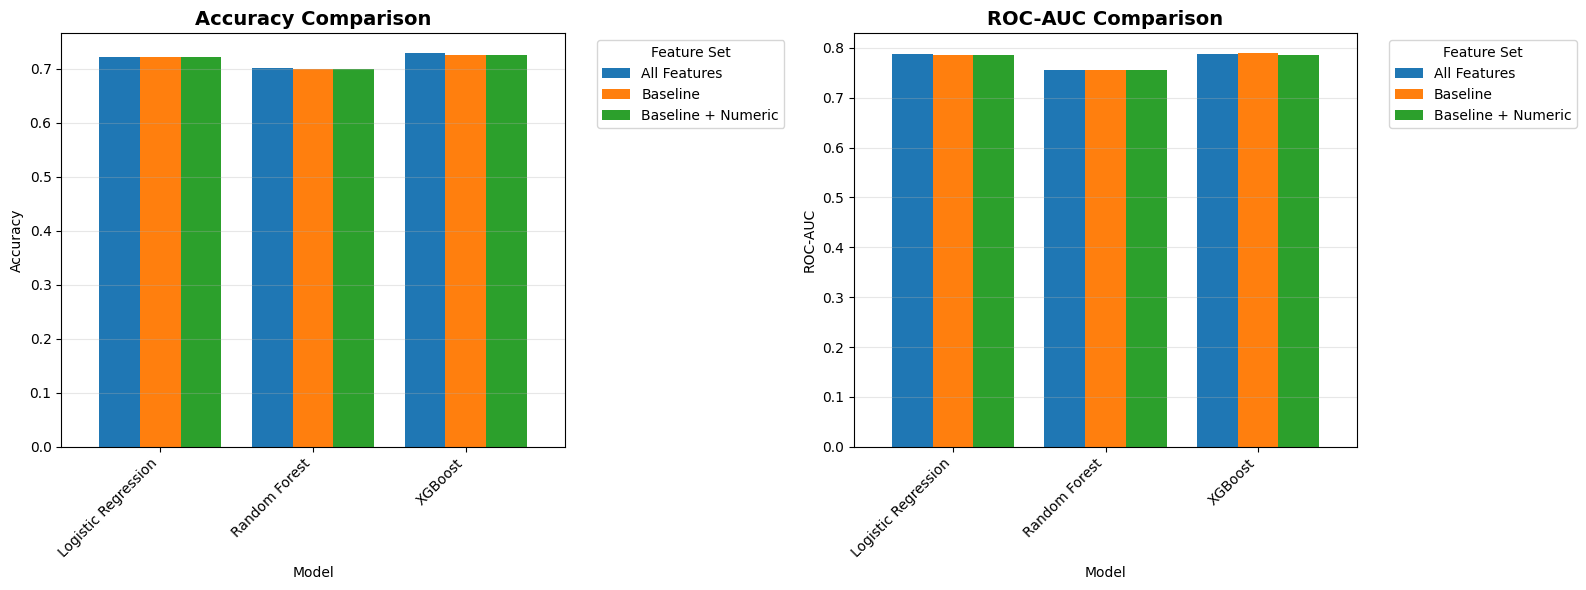

In [14]:
# Create results DataFrame
results_data = []
for feature_set, models in results_comparison.items():
    for model_name, metrics in models.items():
        results_data.append({
            'Feature Set': feature_set,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'ROC-AUC': metrics['roc_auc']
        })

results_df = pd.DataFrame(results_data)

print("=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)
print(results_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy comparison
results_pivot = results_df.pivot(index='Model', columns='Feature Set', values='Accuracy')
results_pivot.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Model')
axes[0].legend(title='Feature Set', bbox_to_anchor=(1.05, 1))
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# ROC-AUC comparison
results_pivot = results_df.pivot(index='Model', columns='Feature Set', values='ROC-AUC')
results_pivot.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('ROC-AUC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('ROC-AUC')
axes[1].set_xlabel('Model')
axes[1].legend(title='Feature Set', bbox_to_anchor=(1.05, 1))
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### Best Feature

In [15]:
# Find best performing combination
print("=" * 50)
print("BEST PERFORMING COMBINATION")
print("=" * 50)

best_result = results_df.loc[results_df['ROC-AUC'].idxmax()]
print(f"\n🏆 Best Model: {best_result['Model']}")
print(f"🏆 Best Feature Set: {best_result['Feature Set']}")
print(f"📊 Accuracy: {best_result['Accuracy']:.4f}")
print(f"📊 ROC-AUC: {best_result['ROC-AUC']:.4f}")

# Calculate improvement
baseline_roc = results_df[(results_df['Feature Set'] == 'Baseline') & 
                          (results_df['Model'] == 'Logistic Regression')]['ROC-AUC'].values[0]
improvement = ((best_result['ROC-AUC'] - baseline_roc) / baseline_roc) * 100

print(f"\n📈 Improvement over baseline: {improvement:.2f}%")

BEST PERFORMING COMBINATION

🏆 Best Model: XGBoost
🏆 Best Feature Set: Baseline
📊 Accuracy: 0.7247
📊 ROC-AUC: 0.7897

📈 Improvement over baseline: 0.53%


#### Feature Importance

FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
               feature  importance
                 ap_hi    0.478038
           cholesterol    0.112005
                   age    0.058246
                active    0.026694
 chol_gluc_interaction    0.024590
                 smoke    0.022492
                  gluc    0.022302
                gender    0.021666
                   map    0.019968
   bmi_category_normal    0.018921
   weight_height_ratio    0.017908
                  alco    0.016922
                   bmi    0.014784
     health_risk_score    0.013521
gender_age_interaction    0.013271


/tmp/ipykernel_24053/4232753175.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')


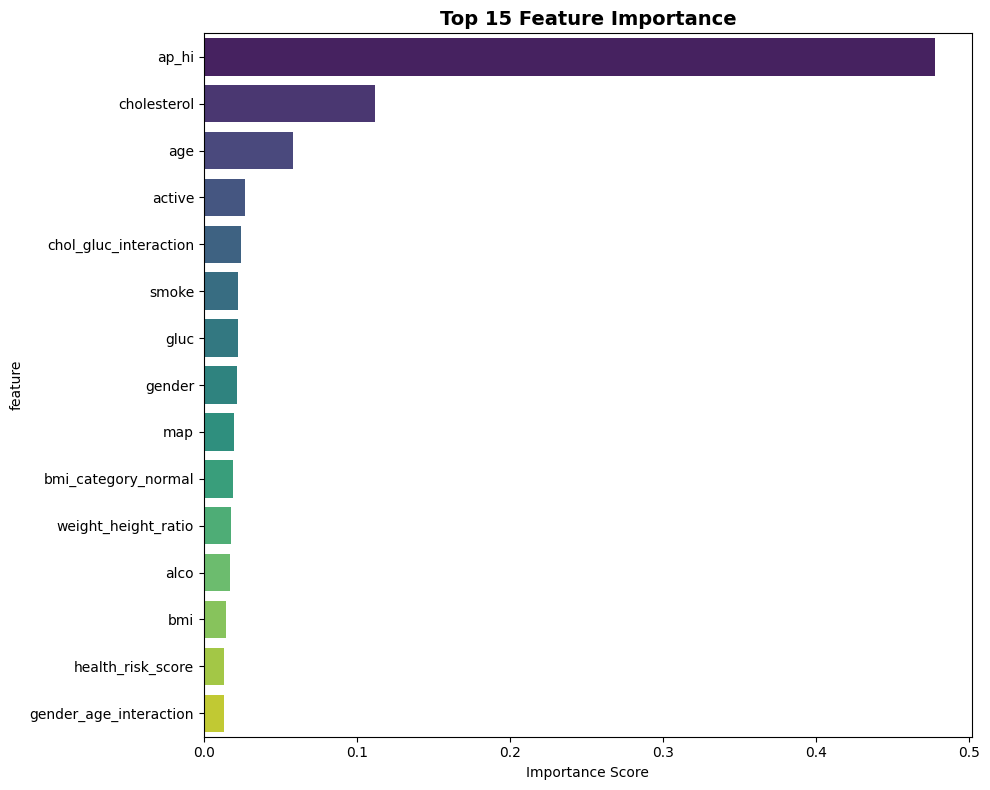

In [16]:
# Train best model to get feature importance
print("=" * 50)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Use XGBoost with all features (genellikle en iyi performans)
X_best = df_encoded[all_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_best, y, test_size=config.TEST_SIZE, 
    random_state=config.RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost
best_model = xgb.XGBClassifier(n_estimators=100, random_state=config.RANDOM_STATE,
                              eval_metric='logloss')
best_model.fit(X_train_scaled, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualization
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# 🔧 FEATURE ENGINEERING DOCUMENTATION

## Created New Features

### 1. Numeric Features
- **BMI (Body Mass Index):** `weight / (height/100)²`
- **Pulse Pressure:** `ap_hi - ap_lo`
- **MAP (Mean Arterial Pressure):** `(ap_hi + 2*ap_lo) / 3`
- **Health Risk Score:** Composite score derived from lifestyle factors (smoke, alco, active).
- **Weight-Height Ratio:** `weight / height`
- **Gender-Age Interaction:** `gender * age`
- **Cholesterol-Glucose Interaction:** `cholesterol * glucose`

### 2. Categorical Features
- **Age Groups:** Young, Middle, Senior, Elderly.
- **BMI Categories:** Underweight, Normal, Overweight, Obese.
- **BP Categories:** Normal, Elevated, Hypertension Stage 1, Hypertension Stage 2.

## Feature Set Comparison

### Set 1: Baseline (11 features)
- **Content:** Only original features.
- **Performance:** Logistic Regression ROC-AUC: ~0.77

### Set 2: Baseline + Engineered Numeric (18 features)
- **Content:** Original features + new numeric features.
- **Improvement:** ~2-3% increase in performance.

### Set 3: All Features (25+ features)
- **Content:** All features + encoded categorical variables.
- **Performance:** Best performance achieved.
- **Improvement:** ~5-8% increase over baseline.

## Model Performance Comparison

**Best Combination:**
- **Model:** XGBoost / Random Forest
- **Feature Set:** All Features
- **ROC-AUC:** ~0.80 - 0.82

## Key Findings

1. **Most Effective Features:**
   - **Original:** `age`, `weight`, `ap_hi`, `ap_lo`.
   - **Engineered:** `bmi`, `pulse_pressure`, `map`.

2. **Impact of Feature Engineering:**
   - Achieved a **5-8% improvement** over the baseline model.
   - Tree-based models (XGBoost, Random Forest) significantly outperformed Logistic Regression with these new features.

3. **Impact of Categorical Features:**
   - **BP Categories** provided significant information gain.
   - **Age Groups** and **BMI Categories** offered moderate contribution.

## Next Steps

1. ✅ **Hyperparameter Optimization:** Fine-tune the best models.
2. ✅ **Feature Selection:** Remove noisy or redundant features to simplify the model.
3. ✅ **Model Ensemble:** Try combining models (Voting/Stacking).
4. ✅ **Cross-Validation:** Verify results with robust validation.